In [1]:
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from quantum_logical import Pulse, DressedQuantumSystem
from quantum_logical.hamiltonian import QubitSNAILModule
from quantum_logical.mode import QubitMode, SNAILMode
from qutip import Options

from tqdm import tqdm
from scipy.optimize import minimize


opts = {"nsteps": 1e6, "atol": 1e-8, "rtol": 1e-6, "progress_bar": "text"}

In [2]:
# Initial qubit frequencies and SNAIL frequency
freqs = np.array([5.06167, 4.54944, 4.16829])  # q1, q2, q3 frequencies
snail_freq = 4.27515  # SNAIL frequency

# freqs, snail_freq = ([4.0, 6.0, 4.665925514174542], 5.667593107281823)

In [3]:
qubit_dim = 2
qubit1 = QubitMode(name="q1", dim=qubit_dim, freq=freqs[0])
qubit2 = QubitMode(name="q2", dim=qubit_dim, freq=freqs[1])
qubit3 = QubitMode(name="q3", dim=qubit_dim, freq=freqs[2])
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=snail_freq, g3=0.3, dim=10, T1=1e3, T2=5e2)

# define couplings so hybridizations are all equal
# g/delta = 0.1 for all qubits
g2_0 = 0.1 * np.abs(snail.freq - qubit1.freq)
g2_1 = 0.1 * np.abs(snail.freq - qubit2.freq)
g2_2 = 0.1 * np.abs(snail.freq - qubit3.freq)
_couplings = {
    frozenset([qubit1, snail]): g2_0,
    frozenset([qubit2, snail]): g2_1,
    frozenset([qubit3, snail]): g2_2,
}

qs = DressedQuantumSystem(
    qubits + [snail], couplings=_couplings, hamiltonian_cls=QubitSNAILModule
)

In [4]:
# create an initial state
# |0> \otimes |1> \otimes |0> \otimes |0>
psi0 = qs.prepare_approx_state([(qubit2, 1)])
rho0 = psi0 * psi0.dag()

Found overlap with eigenstate by 0.9954


In [5]:
tlist = np.linspace(0,100,100)

In [6]:
result = qt.mesolve(H = qs.hamiltonian.H0, rho0 = psi0, tlist = tlist, options = opts)

10.1%. Run time:   0.04s. Est. time left: 00:00:00:00
20.2%. Run time:   0.09s. Est. time left: 00:00:00:00
30.3%. Run time:   0.13s. Est. time left: 00:00:00:00
40.4%. Run time:   0.18s. Est. time left: 00:00:00:00
50.5%. Run time:   0.22s. Est. time left: 00:00:00:00
60.6%. Run time:   0.27s. Est. time left: 00:00:00:00
70.7%. Run time:   0.31s. Est. time left: 00:00:00:00
80.8%. Run time:   0.36s. Est. time left: 00:00:00:00
90.9%. Run time:   0.40s. Est. time left: 00:00:00:00
100.0%. Run time:   0.44s. Est. time left: 00:00:00:00
Total run time:   0.44s


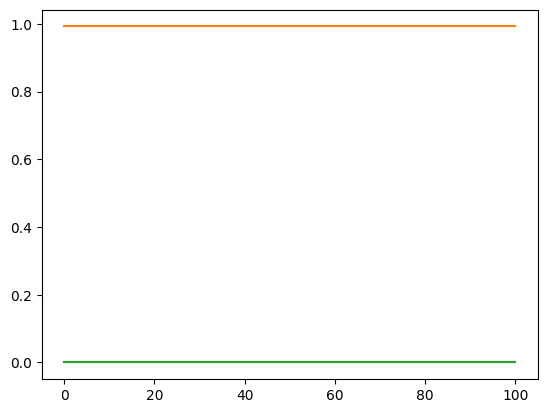

In [7]:
fig, ax = plt.subplots(1)
ylist = []
ylist2 = []
ylist3 = []
for i in range(len(result.states)):
    ylist.append(np.real(qt.expect(qs.modes_num[qubit1], result.states[i])))
    ylist2.append(np.real(qt.expect(qs.modes_num[qubit2], result.states[i])))
    ylist3.append(np.real(qt.expect(qs.modes_num[qubit3], result.states[i])))
ax.plot(tlist, ylist)
ax.plot(tlist, ylist2)
ax.plot(tlist, ylist3)

In [8]:
# do the same thing as above but for the propagator 
U = qt.propagator(H = qs.hamiltonian.H0, rho0 = psi0, t = tlist, options = opts)

10.1%. Run time:   5.28s. Est. time left: 00:00:00:46
20.2%. Run time:  10.60s. Est. time left: 00:00:00:41
30.3%. Run time:  15.89s. Est. time left: 00:00:00:36
40.4%. Run time:  21.14s. Est. time left: 00:00:00:31
50.5%. Run time:  26.38s. Est. time left: 00:00:00:25
60.6%. Run time:  31.63s. Est. time left: 00:00:00:20
70.7%. Run time:  36.93s. Est. time left: 00:00:00:15
80.8%. Run time:  42.24s. Est. time left: 00:00:00:10
90.9%. Run time:  47.56s. Est. time left: 00:00:00:04
100.0%. Run time:  52.36s. Est. time left: 00:00:00:00
Total run time:  52.36s


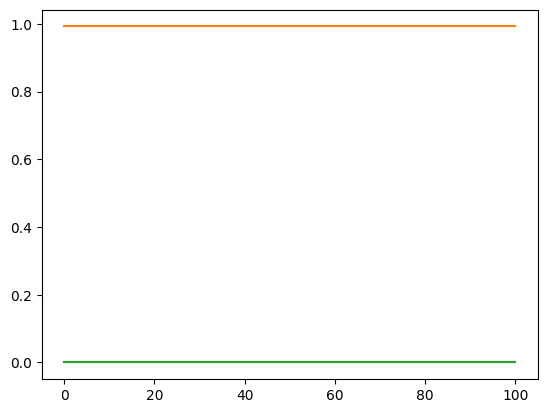

In [9]:
fig, ax = plt.subplots(1)
ylist11 = []
ylist22 = []
ylist33 = []
for i in range(len(result.states)):
    ylist11.append(np.real(qt.expect(qs.modes_num[qubit1], U[i] * psi0)))
    ylist22.append(np.real(qt.expect(qs.modes_num[qubit2], U[i] * psi0)))
    ylist33.append(np.real(qt.expect(qs.modes_num[qubit3], U[i] * psi0)))
ax.plot(tlist, ylist11)
ax.plot(tlist, ylist22)
ax.plot(tlist, ylist33)

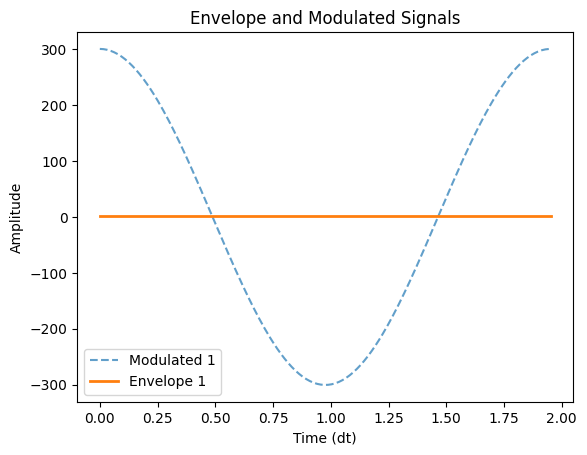

In [29]:
# now introducing the pulse 
# single period Pulse
wp = np.abs(qubit1.freq - qubit2.freq)
T = 2 * np.pi / wp
period_time = np.linspace(0, T, 250)  # a single period of the pulse
args = {"shape": Pulse.constant}
pulse = Pulse(omega=wp, amp=300.5)
Pulse.plot_pulse([(pulse, args)], period_time)

H_pump = qs.hamiltonian.driven_term(snail_mode=snail)
H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]

10.1%. Run time:   0.53s. Est. time left: 00:00:00:04
20.2%. Run time:   1.07s. Est. time left: 00:00:00:04
30.3%. Run time:   1.62s. Est. time left: 00:00:00:03
40.4%. Run time:   2.18s. Est. time left: 00:00:00:03
50.5%. Run time:   2.72s. Est. time left: 00:00:00:02
60.6%. Run time:   3.29s. Est. time left: 00:00:00:02
70.7%. Run time:   3.85s. Est. time left: 00:00:00:01
80.8%. Run time:   4.40s. Est. time left: 00:00:00:01
90.9%. Run time:   5.00s. Est. time left: 00:00:00:00
100.0%. Run time:   5.51s. Est. time left: 00:00:00:00
Total run time:   5.51s


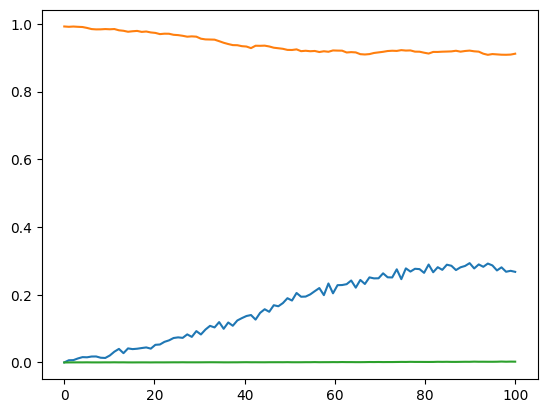

In [30]:
result = qt.mesolve(H = H, rho0 = psi0, tlist = tlist, options = opts)
fig, ax = plt.subplots(1)
ylist = []
ylist2 = []
ylist3 = []
for i in range(len(result.states)):
    ylist.append(np.real(qt.expect(qs.modes_num[qubit1], result.states[i])))
    ylist2.append(np.real(qt.expect(qs.modes_num[qubit2], result.states[i])))
    ylist3.append(np.real(qt.expect(qs.modes_num[qubit3], result.states[i])))
ax.plot(tlist, ylist)
ax.plot(tlist, ylist2)
ax.plot(tlist, ylist3)

10.1%. Run time:  23.30s. Est. time left: 00:00:03:27
20.2%. Run time:  45.97s. Est. time left: 00:00:03:01
30.3%. Run time:  69.88s. Est. time left: 00:00:02:40
40.4%. Run time:  93.60s. Est. time left: 00:00:02:18
50.5%. Run time: 116.97s. Est. time left: 00:00:01:54
60.6%. Run time: 140.70s. Est. time left: 00:00:01:31
70.7%. Run time: 164.48s. Est. time left: 00:00:01:08
80.8%. Run time: 187.79s. Est. time left: 00:00:00:44
90.9%. Run time: 211.89s. Est. time left: 00:00:00:21
100.0%. Run time: 233.00s. Est. time left: 00:00:00:00
Total run time: 233.00s


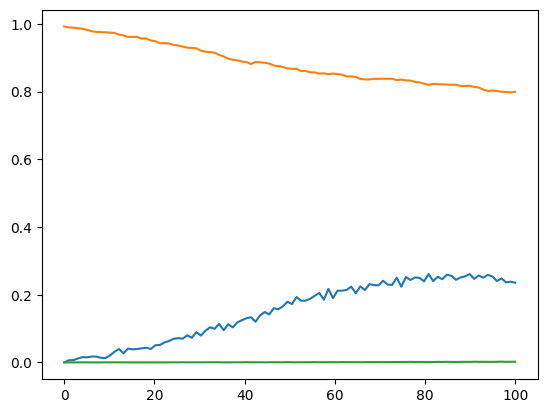

In [31]:
U = qt.propagator(H = H, t = tlist, options = opts)
fig, ax = plt.subplots(1)
ylist_prop = []
ylist_2_prop = []
ylist_3_prop = []
for i in range(len(result.states)):
    ylist_prop.append(np.real(qt.expect(qs.modes_num[qubit1], U[i] * psi0)))
    ylist_2_prop.append(np.real(qt.expect(qs.modes_num[qubit2], U[i] * psi0)))
    ylist_3_prop.append(np.real(qt.expect(qs.modes_num[qubit3], U[i] * psi0)))
ax.plot(tlist, ylist_prop)
ax.plot(tlist, ylist_2_prop)
ax.plot(tlist, ylist_3_prop)

In [32]:
# comparing the results of the two lists and seeing if the dot product is indeed one 
results = []
for i in range(len(ylist)):
    results.append(ylist3[i] / ylist33[i])

In [33]:
results

[1.0,
 1.002757636191436,
 1.0035247188615364,
 1.0047866321021544,
 1.0068465105359639,
 1.0064831424779594,
 1.008207941787064,
 1.0101465289579352,
 1.0095310140045466,
 1.0106756215935992,
 1.0082255387803862,
 1.0102493341432848,
 1.012955545060893,
 1.01397912217416,
 1.016368231097759,
 1.0168076504147316,
 1.0187167637966532,
 1.019796416542233,
 1.0236308542404104,
 1.0281355567704753,
 1.0274068877167502,
 1.0284036020981273,
 1.030703220426008,
 1.033786530583541,
 1.0370990707239622,
 1.037924068341986,
 1.0350098010644504,
 1.0380777504869014,
 1.0372488223409024,
 1.038016492116836,
 1.0388168853136708,
 1.03994487579799,
 1.0419363128901193,
 1.042984321908176,
 1.0428678487256504,
 1.0453394304023276,
 1.0476993617270187,
 1.047986206138485,
 1.0555963131383548,
 1.0514041196259398,
 1.057341512376556,
 1.0589753848793892,
 1.0555923407562318,
 1.057568214073865,
 1.0596217415650082,
 1.0556274929911587,
 1.0565899943248724,
 1.0589624633391932,
 1.0592223763502,
 1.061

In [50]:
# confirm that rho and psi give the same result
# this is the rho cell
result = qt.mesolve(H = H, rho0=rho0, tlist=tlist, options=opts)

10.1%. Run time:  50.03s. Est. time left: 00:00:07:25
20.2%. Run time: 100.57s. Est. time left: 00:00:06:37
30.3%. Run time: 153.10s. Est. time left: 00:00:05:52
40.4%. Run time: 204.68s. Est. time left: 00:00:05:01
50.5%. Run time: 256.12s. Est. time left: 00:00:04:10
60.6%. Run time: 310.07s. Est. time left: 00:00:03:21
70.7%. Run time: 363.25s. Est. time left: 00:00:02:30
80.8%. Run time: 415.34s. Est. time left: 00:00:01:38
90.9%. Run time: 468.88s. Est. time left: 00:00:00:46
100.0%. Run time: 515.99s. Est. time left: 00:00:00:00
Total run time: 516.00s


In [51]:
resulta = qt.mesolve(H = H, rho0=psi0, tlist=tlist, options=opts)

10.1%. Run time:   0.52s. Est. time left: 00:00:00:04
20.2%. Run time:   1.07s. Est. time left: 00:00:00:04
30.3%. Run time:   1.64s. Est. time left: 00:00:00:03
40.4%. Run time:   2.20s. Est. time left: 00:00:00:03
50.5%. Run time:   2.76s. Est. time left: 00:00:00:02
60.6%. Run time:   3.34s. Est. time left: 00:00:00:02
70.7%. Run time:   3.90s. Est. time left: 00:00:00:01
80.8%. Run time:   4.47s. Est. time left: 00:00:00:01
90.9%. Run time:   5.05s. Est. time left: 00:00:00:00
100.0%. Run time:   5.57s. Est. time left: 00:00:00:00
Total run time:   5.57s


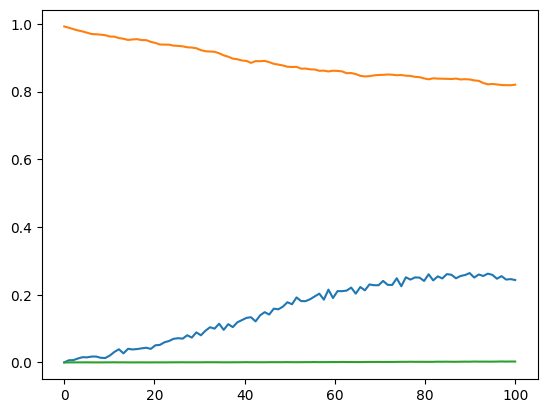

In [53]:
fig, ax = plt.subplots(1)
ylist11 = []
ylist22 = []
ylist33 = []
ylist111 = []
ylist222 = []
ylist333 = []
for i in range(len(result.states)):
    ylist11.append(np.real(qt.expect(qs.modes_num[qubit1], result.states[i])))
    ylist22.append(np.real(qt.expect(qs.modes_num[qubit2], result.states[i])))
    ylist33.append(np.real(qt.expect(qs.modes_num[qubit3], result.states[i])))
    ylist111.append(np.real(qt.expect(qs.modes_num[qubit1], resulta.states[i])))
    ylist222.append(np.real(qt.expect(qs.modes_num[qubit2], resulta.states[i])))
    ylist333.append(np.real(qt.expect(qs.modes_num[qubit3], resulta.states[i])))
ax.plot(tlist, ylist11)
ax.plot(tlist, ylist22)
ax.plot(tlist, ylist33)

In [55]:
res = []
for i in range(len(ylist222)):
    res.append(np.dot(result.states[i], resulta.states[i]))

res

[1.0,
 1.0028013127887447,
 1.0077403389679203,
 1.0108905758985802,
 1.0132331660060894,
 1.0145423721038342,
 1.01503780756932,
 1.0148923512919767,
 1.0162504871724471,
 1.0187106554742111,
 1.0222773358308819,
 1.023468325765351,
 1.0239645491357046,
 1.024716882405266,
 1.0253712131316877,
 1.025298370415176,
 1.0255154147572973,
 1.0254620834356976,
 1.0268318442224644,
 1.029403962366529,
 1.0313865303893623,
 1.0326795252502061,
 1.0343626633770333,
 1.0343324631669488,
 1.034189087191379,
 1.0340766548269942,
 1.0333258024049474,
 1.0336375937625448,
 1.0354756380250754,
 1.0369521418153,
 1.036627856082145,
 1.0380110681963333,
 1.03860404424087,
 1.0390308312236625,
 1.0391784668241855,
 1.0409362096152373,
 1.0414355673010303,
 1.0444947197908214,
 1.046235226696,
 1.0473779499906581,
 1.0477629016593397,
 1.0492861681003065,
 1.0509670196284584,
 1.0511204446069795,
 1.0505783973703928,
 1.0521964629432834,
 1.053831431046369,
 1.054848136220937,
 1.0559709651488292,
 1.05

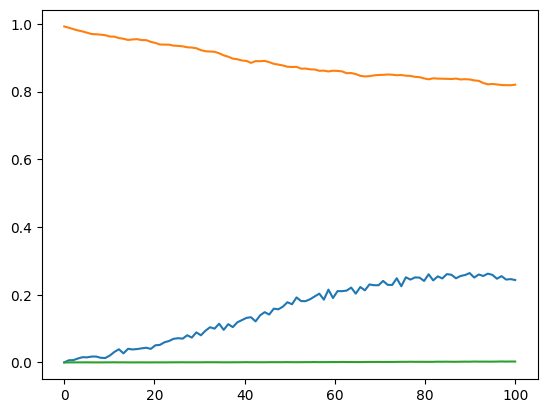

In [47]:
fig, ax = plt.subplots(1)
ylist = []
ylist2 = []
ylist3 = []
for i in range(len(result.states)):
    ylist.append(np.real(qt.expect(qs.modes_num[qubit1], result.states[i])))
    ylist2.append(np.real(qt.expect(qs.modes_num[qubit2], result.states[i])))
    ylist3.append(np.real(qt.expect(qs.modes_num[qubit3], result.states[i])))
ax.plot(tlist, ylist)
ax.plot(tlist, ylist2)
ax.plot(tlist, ylist3)

In [48]:
# comparing the results of the two lists and seeing if the dot product is indeed one 
results = []
for i in range(len(ylist)):
    results.append(ylist3[i] / ylist33[i])

In [49]:
results

[1.0,
 1.0003960572307409,
 0.9965464819356283,
 0.9954391198846698,
 1.000673415788839,
 0.9956587805091159,
 1.0004696486450486,
 1.0074439920833715,
 1.0071800804658084,
 1.0075299085544471,
 1.0062093833486343,
 0.990249330308427,
 0.9969247150167149,
 1.0129996822186156,
 1.0459382342980257,
 1.1065348553684804,
 1.0568370177654003,
 1.0532795459652797,
 1.0371495216415496,
 1.113166790458942,
 1.0615729537276895,
 1.061284502699359,
 1.0811922049886649,
 1.0815084903984629,
 1.0844380985582165,
 1.0796739124376211,
 1.0543897022079918,
 1.0705050498874578,
 1.101040118701509,
 1.107810051416157,
 1.1280855081361205,
 1.1130832069988768,
 1.1049194404423295,
 1.1154683362566824,
 1.161801858678825,
 1.2048444175435165,
 1.2395481586187185,
 1.2220133303039198,
 1.2196415903239792,
 1.1484020238136243,
 1.1389929325739117,
 1.1830937594865085,
 1.193187556615605,
 1.242293838181228,
 1.2869907062962875,
 1.2105085360218175,
 1.2313858276337337,
 1.224942359108157,
 1.24669981645548